# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

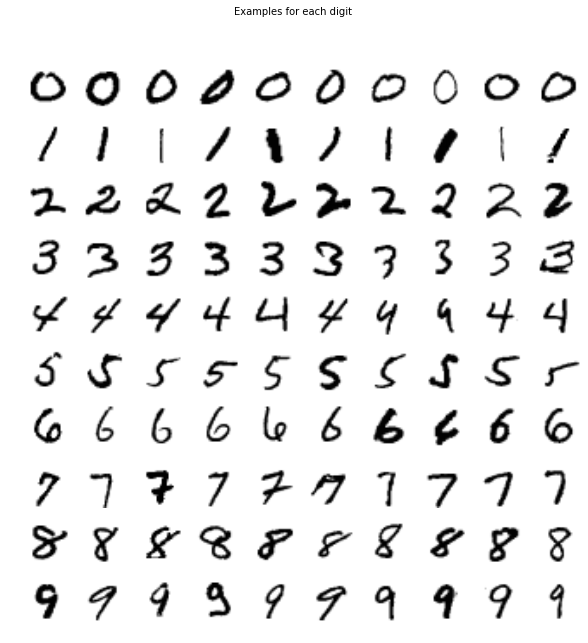

In [3]:
# Setting the image color map to grayscale. This is set gloablly so we wont need to set it everytime.
plt.rc('image', cmap='binary') 

# function to loop through the data set to get  examples for each digit based on input
# A 2d array will be created which will hold the index value of the data set where the digit 
# can be found to paint on the UI
def digit_array(num_examples,labelset):
    try:
        num_examples = int(num_examples)
        if(num_examples == 0):
            print "Please enter number of samples to be greater than 0"
            raise 
        #array to hold the count of samples for each digit
        count_array = np.zeros((10),dtype=int)
        #2D Array to hold the index value for each sample digit that we have found. 
        # we will later use it for printing digit
        data_array = np.zeros((10,num_examples),dtype=int)
        #counter for the total examples we have found
        total_found = 0
        
        # Loop through the dataset
        for i in range ( 0 , len(labelset)):
            # if we have found the number of examples we wanted for the particular digit we move on to next record
            if (count_array[labelset[i]] >= num_examples):
                continue
            # increment count_array 
            count_array[labelset[i]] += 1
            # if cnt_i has not exceeded num examples, we should store value
            if (count_array[labelset[i]] <= num_examples):
                # store index into dig_array for
                data_array[labelset[i]][count_array[labelset[i]] - 1] = i
                # update total example counter everytime we find something to add to dig_array
                total_found += 1
            # if we have found enough samples then break from the for loop
            if (total_found == (10 * num_examples)):
                break
        return data_array
    except ValueError:
        print "Please enter an Integer for number of examples"
        raise
# function to paint the digits 
def paint_digits(index_array,dataset):
    try:
        # create instance of figure
        fig = plt.figure()
        fig.set_size_inches(index_array.shape[0],index_array.shape[1])
        # add subtitle for the image 
        fig.suptitle("Examples for each digit")
        # loop through the data
        for i in range (0, index_array.shape[0]):
            for j in range(0, index_array.shape[1]):
                plt_index =   1 + (i * index_array.shape[1]) + j
                # get the data for the image from the data set
                img_sin = dataset[index_array[i][j]]
                # to plot into 2D We need to first convert the one D array to 2D. We use 28 x 28 here as there are 784 attributes
                img_mat = img_sin.reshape(28,28)
                #now add image to the subplot so we can show the image in a grid
                a = fig.add_subplot(index_array.shape[0],index_array.shape[1],plt_index)
                plt.imshow(img_mat)
                # setting the axis off of the plot so we the final image is cleaner
                plt.axis('off')
    except:
        print "error occured"

def P1 (num_examples):
    try:
        # get the index value for samples using the digit_array function 
        num_arr = digit_array(num_examples,mini_train_labels)
        paint_digits(num_arr,mini_train_data)
    except: 
        print "Error Occured. Please contact developer :)"

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
# function to determine accuracy of the model
# It takes input the predicted labels and expected labels
def accuracy_model(predicted,expected):
    # initialise correct and total counter 
    correct = 0
    total = 0
    #using the zip function to iterate over 2 list 
    for predicted_label, expected_label in zip(predicted, expected):
        # if the predicted and expected labels are same than increment correct
        if predicted_label == expected_label:
            correct += 1
        #increment the total count regardless of whether the label was correct 
        total += 1
    # return total, correct and accuracy = correct / total. 
    # Accuracy is determine as percentage hence multiplied by 100 here
    return {'total':total, 'correct':correct ,'accuracy':(100 * (float(correct) / total)) }

def knn_classifier(k, knn_training_data,knn_training_labels,knn_testing_data,knn_testing_labels, print_report,predicted):
    # trying to use algo as brute as different runs sometimes given different results due to internal shuffling
    # as per Ref: https://github.com/scikit-learn/scikit-learn/issues/365
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    # fit the model on the mini_train data set
    knn_clf.fit(knn_training_data,knn_training_labels)
    #the model is tested on dev_data
    predicted = knn_clf.predict(knn_testing_data)
    #Determine the accuracy of the model    
    model_acc = accuracy_model(predicted, knn_testing_labels)
    total,correct,accuracy = model_acc['total'],model_acc['correct'],model_acc['accuracy']
    print 'Total: %3d  Correct: %3d  Accuracy (in percentage): %3.2f%s with %1d-nn classifier ' %(total, correct, accuracy,'%',k)
    if print_report == True and k == 1:
        print("Classification report for %d-nn classifier:\n%s\n" % (k, classification_report(knn_testing_labels, predicted)))


def P2(k_values):
    for k in k_values:
        predicted = np.zeros(dev_labels.shape)
        knn_classifier(k, mini_train_data,mini_train_labels,dev_data,dev_labels,True,predicted) 

k_values = [1,3,5,7,9]
P2(k_values)

Total: 1000  Correct: 888  Accuracy (in percentage): 88.80% with 1-nn classifier 
Classification report for 1-nn classifier:
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000


Total: 1000  Correct: 878  Accuracy (in percentage): 87.80% with 3-nn classifier 
Total: 1000  Correct: 869  Accuracy (in percentage): 86.90% with 5-nn classifier 
Total: 1000  Correct: 865  Accuracy (in percentage): 86.50% with 7-nn c

ANSWER: Based on the classification report produced for 1-nn classifier, the most difficult digit to predict is '9'
Classification report for 1-nn classifier:
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [5]:
def P3(train_sizes, accuracies):
    # loop through the training sizes
    #accuracies = np.zeros(len(train_sizes))
    for index,t in enumerate(train_sizes):
        # spli the training data & labels based on the input size 
        dataset, labelset = train_data[:t], train_labels[:t]
        # Create and fit a nearest-neighbor classifier with n =1
        knn_clf = KNeighborsClassifier(n_neighbors=1)
        knn_clf.fit(dataset,labelset)
        #calculate the start time before the fit
        start_time = time.time()
        predicted = knn_clf.predict(dev_data)
        #determine the time taken to predict the data
        time_taken = time.time() - start_time
        #Determine the accuracy of the model
        model_acc = accuracy_model(predicted,dev_labels)
        total,correct,accuracy = model_acc['total'],model_acc['correct'],model_acc['accuracy']
        accuracies[index]=round(accuracy,2)
        #print 'Total: %3d  Correct: %3d  Accuracy (in percentage): %3.2f with %1d-nn classifier ' %(total, correct, 100*correct/total,1)
        print 'Size of Data: %d Accuracy (in percentage): %3.2f%s Time taken in secs for prediction: %3.4f ' %(t,accuracy,'%',time_taken)
        
#train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
train_sizes = [100, 200, 400, 800,1600,3200, 6400, 12800, 25000]
accuracies = np.zeros(len(train_sizes))
P3(train_sizes, accuracies)
print accuracies

Size of Data: 100 Accuracy (in percentage): 72.00% Time taken in secs for prediction: 0.1012 
Size of Data: 200 Accuracy (in percentage): 78.60% Time taken in secs for prediction: 0.1862 
Size of Data: 400 Accuracy (in percentage): 84.10% Time taken in secs for prediction: 0.3866 
Size of Data: 800 Accuracy (in percentage): 88.40% Time taken in secs for prediction: 0.7919 
Size of Data: 1600 Accuracy (in percentage): 90.20% Time taken in secs for prediction: 1.5453 
Size of Data: 3200 Accuracy (in percentage): 92.60% Time taken in secs for prediction: 3.1061 
Size of Data: 6400 Accuracy (in percentage): 93.70% Time taken in secs for prediction: 6.3387 
Size of Data: 12800 Accuracy (in percentage): 95.90% Time taken in secs for prediction: 12.5241 
Size of Data: 25000 Accuracy (in percentage): 97.00% Time taken in secs for prediction: 25.8830 
[ 72.   78.6  84.1  88.4  90.2  92.6  93.7  95.9  97. ]


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

The predicted accuracy for train_size of 60000 is :  124.307226036


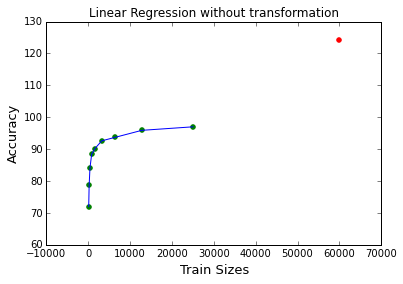

The predicted accuracy for train_size of 60000 after log transformtion is :  103.386513757


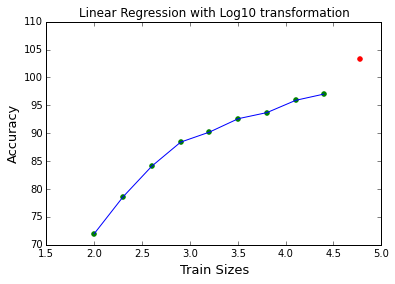

In [6]:
def P4():    
    # Create and fit a Linear Regression 
    regr = LinearRegression()
    # converting the train_sizes into vector as its a list
    train_size_vec = np.reshape(train_sizes,(len(train_sizes),1))
    # Train the model using the training sets
    regr.fit(train_size_vec,accuracies)
    ## Now predict the accuracy for 60000
    predicted = regr.predict(60000)
    print "The predicted accuracy for train_size of 60000 is : ",predicted[0]
    
    #creating a plot to see what kind of relationship exist
    plt.scatter(np.array(train_sizes), accuracies, color='green')
    plt.plot(np.array(train_sizes), accuracies, color='blue')
    plt.scatter(60000, predicted, color='red')
    plt.xlabel('Train Sizes',fontsize=13)
    plt.ylabel('Accuracy',fontsize=13)
    plt.autoscale(enable=True, axis=u'both', tight=False)
    plt.grid(False)
    plt.title("Linear Regression without transformation")
    plt.show()
    
    # applying log transformation to see if it will improve prediction
    regr.fit(np.log10(train_size_vec),accuracies)
    predicted = regr.predict(np.log10(60000))
    print "The predicted accuracy for train_size of 60000 after log transformtion is : ",predicted[0]
    plt.scatter(np.array(np.log10(train_sizes)), accuracies, color='green')
    plt.plot(np.array(np.log10(train_sizes)), accuracies, color='blue')
    plt.scatter(np.log10(60000), predicted, color='red')
    plt.xlabel('Train Sizes',fontsize=13)
    plt.ylabel('Accuracy',fontsize=13)
    plt.autoscale(enable=True, axis=u'both', tight=False)
    plt.grid(False)
    plt.title("Linear Regression with Log10 transformation")
    plt.show()
P4()

ANSWER: From the first graph we can see that relationship between training size and accuracy is not linear. The accuracy for n=60000 is around 124%. After applying log transformation we can see the accuracy has decreased but it is still greater than 100%. The accuracy after transformation is around 103%

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Confusion matrix:
[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]
Confused digits 4 9 23


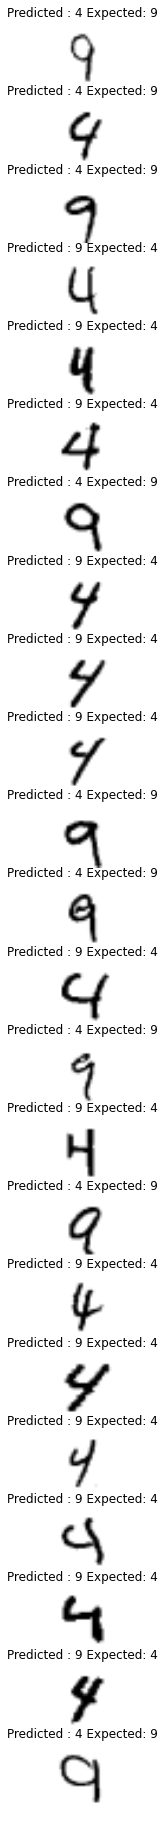

In [7]:
def P5():
    try:
        # Create and fit a Knn classifier 
        knn_clf = KNeighborsClassifier(n_neighbors=1)
        knn_clf.fit(mini_train_data,mini_train_labels)
        predicted = knn_clf.predict(dev_data)
        # generate the confusion matrix on dev data
        conf_matrix = confusion_matrix(dev_labels, predicted)
        print("Confusion matrix:\n%s" % conf_matrix)
        
        # create confusion array confused_total[i][j]
        confused_total = np.zeros((10,10),dtype=int)
        max_confused_i = 0
        max_confused_j = 0
        max_total_seen = 0
        #find most confused pair of digits. we are going to see which pair of digits have the highest confusion. 
        for i in range(0,10): 
            for j in range(i+1,10):
                confused_total[i][j] = conf_matrix[i][j] + conf_matrix[j][i]
                if confused_total[i][j] > max_total_seen : 
                    max_total_seen = confused_total[i][j]
                    max_confused_i = i  
                    max_confused_j = j  
        print "Confused digits" , max_confused_i , max_confused_j, max_total_seen
        
        # counter for the subplot 
        cnt_ind = 0
        #set the plot colour to binary 
        plt.rc('image', cmap='binary') 
        fig = plt.figure()
        #get the current size of the figure
        Size = fig.get_size_inches()
        #increase the figure size so the example digits are clearly visible
        fig.set_size_inches(Size[0]*8, Size[1]*8, forward=True)   
        #loop through the predicted and expected labels and print sample
        for index, (predicted_label, expected_label) in enumerate(zip(predicted, dev_labels)):
            # if the expected label is from the above confused pair of digit we want to display it 
            if (expected_label == max_confused_i and predicted_label == max_confused_j) or (expected_label == max_confused_j and predicted_label == max_confused_i):
                # increment the counter by 1
                cnt_ind += 1
                # get the image data from dev_data
                img_sin = dev_data[index]
                #transform the data into matrix
                img_mat = img_sin.reshape(28,28)
                a = fig.add_subplot(max_total_seen, 1, cnt_ind)
                plt.imshow(img_mat)
                # add title each plot
                str = 'Predicted : %1.0f Expected: %1.0f' %(predicted_label,expected_label)
                a.set_title(str)
                plt.axis('off')
    except:
        raise
P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

Sigma:  1 
Gaussian Kernel [[0.0751, 0.1238, 0.0751], [0.1238, 0.2042, 0.1238], [0.0751, 0.1238, 0.0751]] 

Neither training nor dev data was pre processed:
Accuracy of the model 88.8
Confusion matrix:
[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]

Training data was preprocessed but dev data was not:
Accuracy of the model 90.5
Confusion matrix:
[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 104   1   0   0   0   0   0   0   0]
 [  3   2  85   4   0   0   0   3   4   1]
 [  0   0   1  75   0   4   0   2   2   2]
 [  0   0   0   0  85   0   2   2   1  14]
 [  2   0   0   7   0  80   0   0   1   1]
 [  2   1 

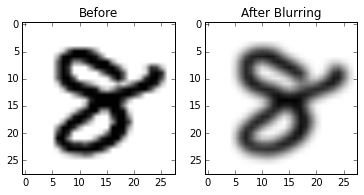

In [8]:
import math

#function to determine the gaussian kernel for blur function 
# for pixel we calculate the gaussian kernel using the gaussian function and co-ordinates of that point i.e 
# i,j (x,y in the code below)
# we are assuming that the center point of the kernel is (0,0) and we need to calculate rest all values
def gauss_kernel(sigma, n):
    neg_n = int(-1 * (n-1) / 2)
    pos_n = int((n + 1)/ 2) 
    kernel = []
    sum = 0
    for x in range(neg_n, pos_n):
        col = []
        for y in range(neg_n, pos_n):
            t = ( 1 / ( 2 * math.pi * math.pow(sigma,2) ) ) * ( math.exp ( -1 * ( math.pow(x, 2) + math.pow(y, 2) ) / ( 2 * math.pow(sigma, 2) ) ) ) 
            sum += t
            col.append(t)
        kernel.append(col)   

    # this is for normalising the kernel generated above.    
    g_kernel = []
    for x in range(0, n):
        g_kernel_col = []
        for y in range(0, n):
            g_kernel_col.append(round((kernel[x][y]/sum),4))
        g_kernel.append(g_kernel_col)
    return g_kernel

#function to blur a single cell in a matrix using its neighbours and the gaussian kernel
# this function takes care of boundary conditions.
# for example if we are trying to apply the smoothing to pixel 0 below , its neighbour are only 1,3,&4.
# Only works for kernel of 3x3
def blur_value (img_matrix, x, y, n, kernel):
    # 0 1 2
    # 3 4 5
    # 6 7 8
    # x,y is 4
    sum = 0
    ctr = 0
    for i in range(0,9):
        if i == 0:
            if x == 0:
                continue
            if y == (n-1):
                continue
            ctr += kernel[0][0]
            sum += (kernel[0][0] * img_matrix[x-1][y+1])
        if i == 1:
            if y == (n-1):
                continue
            ctr += kernel[0][1]
            sum += (kernel[0][1] * img_matrix[x][y+1])
        if i == 2:
            if x == (n-1):
                continue
            if y == (n-1):
                continue
            ctr += kernel[0][2]
            sum += (kernel[0][2] * img_matrix[x+1][y+1])
        if i == 3:
            if x == 0:
                continue
            ctr += kernel[1][0]
            sum += (kernel[1][0] * img_matrix[x-1][y])
        if i == 4:
            ctr += kernel[1][1]
            sum += (kernel[1][1] * img_matrix[x][y])
        if i == 5:
            if x == (n-1):
                continue
            ctr += kernel[1][2]
            sum += (kernel[1][2] * img_matrix[x+1][y])
        if i == 6:
            if x == 0:
                continue
            if y == 0:
                continue
            ctr += kernel[2][0]
            sum += (kernel[2][0] * img_matrix[x-1][y-1])
        if i == 7:
            if y == 0:
                continue
            ctr += kernel[2][1]
            sum += (kernel[2][1] * img_matrix[x][y-1])
        if i == 8:
            if x == (n-1):
                continue
            if y == 0:
                continue
            ctr += kernel[2][2]
            sum += (kernel[2][2] * img_matrix[x+1][y-1])
    # computing final blurred value
    # for edges we ignore absent cells and adjust weight accordingly
    # hence the need to divide by ctr which is a sum of weightages of the present cells
    blurred_val = round((sum/ctr),4)
    return blurred_val

# function to blur a single matrix image 
def blur_matrix(img_matrix, n, kernel):
    blurred = np.zeros(img_matrix.shape)
    for i in range(0,n):
        for j in range(0,n):
            blurred[i][j] = blur_value(img_matrix,i,j,n,kernel)
    return blurred
 
# function to blur the data set
def blur_image(img_data,size,kernel):
    blurred_image = np.zeros(img_data.shape)
    for i in range(0,(img_data.shape[0])):
        img_mat = img_data[i].reshape(28,28)
        blur = blur_matrix(img_mat, size, kernel)
        blurred_image[i] = blur.reshape(784)            
    return blurred_image
    

def P6():
    # setting sigma , kernel size and size of the image matrix
    # this allows us to change the sigma 
    sigma = 1
    kernel_size = 3
    size = 28
    #initialise the gaussain kernel that will be used
    kernel = gauss_kernel(sigma,kernel_size)
    print 'Sigma: %2.0f \nGaussian Kernel %s ' %(sigma,kernel)
    
    # blurring training and dev_data
    blurred_train = blur_image(mini_train_data,size,kernel)
    blurred_dev =  blur_image(dev_data,size,kernel)
    
    #plotting a sample image 
    fig = plt.figure()
    plt.rc('image', cmap='binary') 
    a = fig.add_subplot(1, 2, 1)
    a.set_title('Before')
    plt.imshow(mini_train_data[6].reshape(28,28))
    a = fig.add_subplot(1, 2, 2)
    a.set_title('After Blurring')
    plt.imshow(blurred_train[6].reshape(28,28))
    

    #initialising the knn classifier with n =1
    k1n_clf = KNeighborsClassifier(n_neighbors=1)
    
    #without preprocesing data
    print "\nNeither training nor dev data was pre processed:"

    # fit the model on the mini_train data set
    k1n_clf.fit(mini_train_data,mini_train_labels)
    #the model is tested on dev_data
    predicted = k1n_clf.predict(dev_data)
    #Determine the accuracy of the model    
    print "Accuracy of the model", k1n_clf.score(dev_data,dev_labels)*100
    print "Confusion matrix:\n", confusion_matrix(dev_labels, predicted)

        
    #preprocess the training data but not the dev data
    print "\nTraining data was preprocessed but dev data was not:"
    k1n_clf.fit(blurred_train,mini_train_labels)
    #the model is tested on dev_data
    predicted = k1n_clf.predict(dev_data)
    #Determine the accuracy of the model    
    print "Accuracy of the model", k1n_clf.score(dev_data,dev_labels)*100
    print"Confusion matrix:\n", confusion_matrix(dev_labels, predicted)
    
    #preprocess the dev data but not the training data
    print "\nDev data was preprocessed but Training data was not:"
    k1n_clf.fit(mini_train_data,mini_train_labels)
    #the model is tested on dev_data
    predicted = k1n_clf.predict(blurred_dev)
    print "Accuracy of the model", k1n_clf.score(dev_data,dev_labels)*100
    print "Confusion matrix:\n", confusion_matrix(dev_labels, predicted)
    
    #preprocess both training and dev data
    print "\nBoth Training & Dev data were preprocessed :"
    k1n_clf.fit(blurred_train,mini_train_labels)
    #the model is tested on dev_data
    predicted = k1n_clf.predict(blurred_dev)
    print "Accuracy of the model", k1n_clf.score(dev_data,dev_labels)*100
    print "Confusion matrix:\n", confusion_matrix(dev_labels, predicted)


P6()

ANSWER: Preprocessing of the data helps with the accuracy of the model. Preprocessing the training data helps. When training data is not preprocessed, accuracy does not improve as we can see from above. It does help slightly with the confused pair of digits that we found with 4 & 9.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [9]:
# Define a function that applies a threshold to turn grayscale digit features into 0/1 features.
def binarize_data(data, threshold=0.5):
    # Initialize a new feature array with the same shape as the original data.
    binarized_data = np.zeros(data.shape)

    # check whether each feature is greater than threshold and assign 0 or 1 based on it
    for feature in range(data.shape[1]):
        binarized_data[:,feature] = data[:,feature] > threshold
    return binarized_data


# Define a function to transform data to 0,1,2
def transform_data(data):
    # Initialize a new feature array with the same shape as the original data.
    gray_data = np.zeros(data.shape)

    # We will map each feature to either 0 = White, 1 = Gray or 2= Black.
    # If the value of the original feature is 0 then it is mapped to 0 (white)
    # If the value of the original feature is 1 then it is mapped to 2 ( black)
    # If the value of the original feature is >0 but < 1 then it is mapped to 1 (gray)
    for row in range (data.shape[0]):
        for feature in range(data.shape[1]):
            if(data[row][feature] == 0):
                gray_data[row][feature] = 0
            if(data[row][feature] == 1):
                gray_data[row][feature] = 2
            if(data[row][feature] > 0 and data[row][feature] < 1):
                gray_data[row][feature] = 1
            
    return gray_data

def P7():
    try:
        # Create new binarized training and test data
        binarized_train_data = binarize_data(mini_train_data)
        binarized_test_data = binarize_data(dev_data)

        #create 0,1,2 training and test data
        gray_train_data = binarize_data(mini_train_data)
        gray_test_data = binarize_data(dev_data)

        alpha = 1
        print "Using sklearn's BernoulliNB classifier"
        clf = BernoulliNB(alpha=alpha)
        clf.fit(binarized_train_data, mini_train_labels)
        print 'BernoulliNB accuracy: %3.2f' %clf.score(binarized_test_data, dev_labels)

        alpha = 1
        print "Using sklearn's MultinomialNB classifier"
        clf = MultinomialNB(alpha=alpha)
        clf.fit(gray_train_data, mini_train_labels)
        print 'MultinomialNB accuracy: %3.2f' %clf.score(gray_test_data, dev_labels)
    except Exception as e:
        print "Exception Occured: ", e.args
        raise

P7()

Using sklearn's BernoulliNB classifier
BernoulliNB accuracy: 0.82
Using sklearn's MultinomialNB classifier
MultinomialNB accuracy: 0.80


ANSWER: Multinomial NB model does not improve accuray. 

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [11]:
def P8(alphas):
    try:
        # function to predict which alpha value is good for BernoulliNB
        # use the function that we created above to convert data to binary values
        binarized_train_data = binarize_data(mini_train_data)
        binarized_test_data = binarize_data(dev_data)
        # create  Bernolli NB Classifier
        bnb = BernoulliNB()
        # Create and Initialise GridSearch  and fit on the binarized training data
        clf = GridSearchCV(bnb, alphas)
        clf.fit(binarized_train_data,mini_train_labels)
        print "Best Parameter found on Training data: ", clf.best_estimator_ 
        print("Grid scores on Mini Train set:")
        for params, mean_score, scores in clf.grid_scores_:
            print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))
        print("Detailed classification report:")
        print("The model is trained on the Mini Train set.")
        print("The scores are computed on the Dev set.")
        y_true, y_pred = dev_labels, clf.predict(binarized_test_data)
        print(classification_report(y_true, y_pred))
        return clf.best_estimator_
    except Exception as e:
        print "Exception Occured: ", e.args

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)
print "Best Parameter: ",nb

 Best Parameter found on Training data:  BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
Grid scores on Mini Train set:
0.092 (+/-0.002) for {'alpha': 0.0}
0.818 (+/-0.044) for {'alpha': 0.0001}
0.820 (+/-0.041) for {'alpha': 0.001}
0.821 (+/-0.036) for {'alpha': 0.01}
0.816 (+/-0.039) for {'alpha': 0.1}
0.803 (+/-0.032) for {'alpha': 0.5}
0.802 (+/-0.035) for {'alpha': 1.0}
0.797 (+/-0.037) for {'alpha': 2.0}
0.760 (+/-0.028) for {'alpha': 10.0}
Detailed classification report:
The model is trained on the Mini Train set.
The scores are computed on the Dev set.
             precision    recall  f1-score   support

        0.0       0.92      0.97      0.95        99
        1.0       0.88      0.92      0.90       105
        2.0       0.83      0.79      0.81       102
        3.0       0.62      0.76      0.68        86
        4.0       0.90      0.78      0.84       104
        5.0       0.78      0.68      0.73        91
        6.0       0.89      0.90     

In [19]:
#print nb.best_params_

ANSWER: When alpha = 0 , we are assuming that the data that does not exist in the model training data is not going to exist in the dev data. Due to this we are getting very low accuracy of 9%. Also alpha =0 means we are trying to overfit the data to the model due to which accuracy goes down and the model is not able to generalise.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

Accuracy of the model before transformation:  62.7
Accuracy of the model after transformation:  85.6


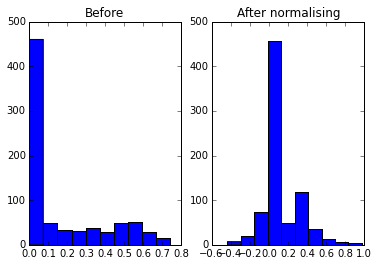

In [12]:
#convert data to normal distribution using mean and variance
def convert_normal(data,labels,theta,sigma):
    normal_data = np.zeros(data.shape,dtype=int)
    for i in range (0,data.shape[0]):
         for j in range (0,data.shape[1]):
            label = labels[i]
            normal_data[i][j]= (data[i][j] - theta[label][j]) / sigma[label][j]
    return normal_data

def P9():
    try:
        # fit and initialise Gaussian NB
        gnb_clf = GaussianNB()
        gnb_clf.fit(mini_train_data, mini_train_labels)
        predicted = gnb_clf.predict(dev_data)
        print "Accuracy of the model before transformation: ", gnb_clf.score(dev_data,dev_labels)*100
        # get the mean and variance of the model
        theta = gnb_clf.theta_
        sigma = gnb_clf.sigma_
        #Gaussian NB requires a gaussian distribution of data
        # Normalising the train and dev data
        normal_train_data = convert_normal(mini_train_data,mini_train_labels,theta,sigma)
        normal_dev_data = convert_normal(dev_data,dev_labels,theta,sigma)
        gnb_clf.fit(normal_train_data, mini_train_labels)
        predicted = gnb_clf.predict(normal_dev_data)
        print "Accuracy of the model after transformation: ", gnb_clf.score(normal_dev_data,dev_labels)*100
        post_theta = gnb_clf.theta_
        fig = plt.figure()
        a = fig.add_subplot(1, 2, 1)
        a.set_title('Before')
        plt.hist(theta[0])
        a = fig.add_subplot(1, 2, 2)
        a.set_title('After normalising')
        plt.hist(post_theta[0])
    except Exception as e:
        print "Exception Occured: ", e.args
        raise

P9()

ANSWER: GaussianNB assumes that the data it is being trained follows Gaussian ( normal ) distribution. In our case the data the model was trained on was not normally distributed. Hence, normalising both the training and test data helped with the accuracy of the model.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

Bernoulii class probability: 
[ 0.092  0.106  0.106  0.112  0.091  0.088  0.101  0.101  0.092  0.111]
20


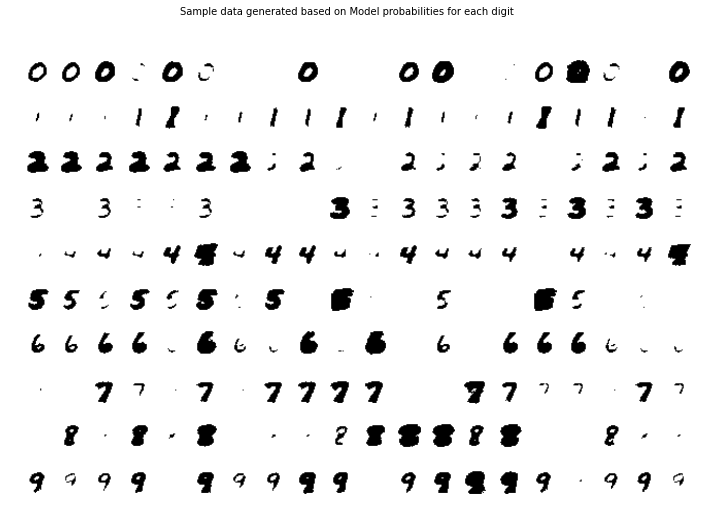

In [13]:
#function that takes input  number of examples of each digit that needs to be printed
def P10(num_examples):
    try:
        num_examples = int(num_examples)
        if(num_examples == 0):
            print "Please enter number of samples to be greater than 0"
            raise 
        alpha = 0.01
        # Converting mini train data to Binary
        binarized_train_data = binarize_data(mini_train_data)
        # create  Bernolli NB Classifier
        bnb = BernoulliNB(alpha=alpha)
        bnb.fit(binarized_train_data,mini_train_labels)
        print "Bernoulii class probability: \n", np.exp(bnb.class_log_prior_)
        #Get the feature probability 
        feature_prob = np.exp(bnb.feature_log_prob_)

        fig = plt.figure()
        Size = fig.get_size_inches()
        #increase the figure size so the example digits are clearly visible
        fig.set_size_inches(Size[0]*2, Size[1]*2, forward=True) 
        # add subtitle for the image 
        fig.suptitle("Sample data generated based on Model probabilities for each digit")
        print num_examples
        for i in range (0,feature_prob.shape[0]):
            #sample_digit = np.zeros((num_examples,feature_prob.shape[1]),dtype=int)
            for j in range(0,num_examples):
                sample_prob = np.random.rand()
                sample_digit = np.transpose(np.array([ sample_prob < mod_prob for mod_prob in feature_prob[i]]))
                plt_index = 1+ j + (i * num_examples)
                a = fig.add_subplot(10,num_examples,plt_index)
                plt.imshow(np.reshape(sample_digit,(28,28)))
                # setting the axis off of the plot so we the final image is cleaner
                plt.axis('off')
           
    except Exception as e:
        print "Exception Occured: ", e.args
        raise 

P10(20)

ANSWER: Looking at the sample of the generated digits , for each digit there are some samples which are not visible. It seems from the examples above that 2,1,7 feature probabilities have been more accurate compared to rest all. 5 is the worst performing digit. The samples produces are similar to the hand written digit. 

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [14]:
# function to find the bucket that prob belongs to
def find_bucket_index(buckets, prob):
    bucket_index = -1
    if prob < 0 or prob > 1:
        print "Invalid prob: ", prob, " : Cannot not map to bucket"
        raise
    for i in range(0,len(buckets)):
        if (prob <= buckets[i]):
            bucket_index = i
            break
    return bucket_index

def P11(buckets, correct, total):
    try:
        alpha = 0.01
        # convert data to binary
        binarized_train_data = binarize_data(mini_train_data)
        binarized_test_data = binarize_data(dev_data)
        expected = dev_labels
        # create  Bernolli NB Classifier with alpha 
        bnb = BernoulliNB(alpha=alpha)
        bnb.fit(binarized_train_data,mini_train_labels)
        # run the model on binarised dev data
        predicted = bnb.predict(binarized_test_data)
        #get the predicted probabilities
        predict_prob = bnb.predict_proba(binarized_test_data)
        
        #determine which bucket range for  each of the feature probability fits in
        for i in range(0,predict_prob.shape[0]):
            # we are going to find what was the maximum probability for that feature using argmax
            # if the predicted and expected are same increment the correct count 
            buc_index = find_bucket_index(buckets, predict_prob[i][predict_prob[i].argmax()])
            if (predicted[i] == expected[i]):
                correct[buc_index] += 1.0
            total[buc_index] += 1.0
    except Exception as e:
        print "Exception Occured: ", e.args
        
buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  30    accuracy = 0.200
p(pred) <= 0.9990000000000    total =  87    accuracy = 0.460
p(pred) <= 0.9999900000000    total =  84    accuracy = 0.619
p(pred) <= 0.9999999000000    total =  58    accuracy = 0.690
p(pred) <= 0.9999999990000    total =  59    accuracy = 0.763
p(pred) <= 0.9999999999900    total =  76    accuracy = 0.868
p(pred) <= 0.9999999999999    total =  75    accuracy = 0.840
p(pred) <= 1.0000000000000    total = 531    accuracy = 0.953


ANSWER: Looking at the data we can say that Naive bayes is not a strongly calibrated model as accuracy and posterior probability are not roughly the same. Neither is it a poorly calibrated model as there is a correlation between posterior probability and accuracy as we can see from above.
It is a weakly calibrated model because the accuracy increased as posterior probability approaches 1.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [58]:
# extend features with a feature that counts no. of whitespaces in digits
# 0, 6, 9 have 2
# 1, 2, 3, 4 5, 7 have 1 ( 4 is not written enclosed - trying to reduce confusion with 9)
# 8 has 3
def update_train_data1(train_data_p12, train_labels_p12):
    feature_cnt = train_data_p12.shape[1]+1
    updated_train_data = np.zeros([train_data_p12.shape[0], feature_cnt])    
    for i in range(0, train_labels_p12.shape[0]):
        if train_labels_p12[i] == 0:
            updated_train_data[i][feature_cnt-1] = 2
        if train_labels_p12[i] == 1:
            updated_train_data[i][feature_cnt-1] = 1
        if train_labels_p12[i] == 2:
            updated_train_data[i][feature_cnt-1] = 1
        if train_labels_p12[i] == 3:
            updated_train_data[i][feature_cnt-1] = 1
        if train_labels_p12[i] == 4:
            updated_train_data[i][feature_cnt-1] = 1
        if train_labels_p12[i] == 5:
            updated_train_data[i][feature_cnt-1] = 1
        if train_labels_p12[i] == 6:
            updated_train_data[i][feature_cnt-1] = 2
        if train_labels_p12[i] == 7:
            updated_train_data[i][feature_cnt-1] = 1
        if train_labels_p12[i] == 8:
            updated_train_data[i][feature_cnt-1] = 3
        if train_labels_p12[i] == 9:
            updated_train_data[i][feature_cnt-1] = 2
        for j in range(0,feature_cnt-1):
            updated_train_data[i][j] = train_data_p12[i][j]
    return updated_train_data      
            

def P12():
    try: 
        # Calculate initial score with normalized data
        gnb_clf = GaussianNB()
        gnb_clf.fit(mini_train_data, mini_train_labels)  
        theta = gnb_clf.theta_
        sigma = gnb_clf.sigma_
        normal_train_data = convert_normal(mini_train_data,mini_train_labels,theta,sigma)
        normal_dev_data = convert_normal(dev_data,dev_labels,theta,sigma)
        gnb_clf.fit(normal_train_data, mini_train_labels)  
#         predicted = gnb_clf.predict(normal_dev_data)
        print "Accuracy of the model before update: ", gnb_clf.score(normal_dev_data,dev_labels)*100

        # Calculate new score with normalized and updated training data
        updated_training_data1 = update_train_data1(normal_train_data, mini_train_labels)
        updated_dev_data1 = update_train_data1(normal_dev_data, dev_labels)
        print "Training shape:",updated_training_data1.shape
        print "Dev shape:",updated_dev_data1.shape

        gnb_clf.fit(updated_training_data1, mini_train_labels)
#         predicted = gnb_clf.predict(updated_dev_data1)
        print "Accuracy of the model after update: ", gnb_clf.score(updated_dev_data1,dev_labels)*100
    except Exception as e:
        print "Exception Occured: ", e.args
    
P12()

Accuracy of the model before update:  85.6
Training shape: (1000, 785)
Dev shape: (1000, 785)
Accuracy of the model after update1:  85.6


#### 